In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [2]:
np.random.RandomState(123)

RandomState(MT19937) at 0x7FB35B894540

In [3]:
#importing datasets
linear_data = pd.read_csv("../data/modeling/linear_data.csv",index_col = 0)
airbnb = pd.read_csv('../data/modeling/airbnb.csv', index_col = 0)
targets = pd.read_csv('../data/modeling/targets.csv', index_col = 0)
colinear = pd.read_csv('../data/modeling/co_linear.csv', index_col = 0)

In [4]:
airbnb=airbnb.drop(columns = targets.columns)

In [5]:
print(linear_data.shape)#colinear features have been removed from this dataset. 
                         #only the 20 features most correlated

print(airbnb.shape)     #dataset with all features 

(2222, 20)
(2222, 221)


# Creating a Hold Out Set

Splitting the data first ensures the same training and test sets are used for all the models. 

In [6]:
#checks to make sure data is still indexed the same by taking a 
#column with continuous values and making sure it is the same 
#across least manipulated and most manipulated dataset. 
#
print((linear_data["reviews_per_month"]==airbnb["reviews_per_month"]).unique())

[ True]


In [7]:
y = targets['price'] #chooses target variable
test_size = .3 #chooses test size

X_train, X_test, y_train, y_test = train_test_split(airbnb, y, test_size = test_size)#splits data for decision tree model
def split(data):#takes in data a returns split data with the same train and test data with the same index as original split
    train = data.iloc[list(X_train.index)]
    test = data.iloc[list(X_test.index)]
    return train, test

X_train_lin, X_test_lin = split(linear_data)#splits linear data

In [8]:
#makes sure everything is indexed the same.
list(X_train.index)==list(X_train_lin.index)==list(y_train.index)
        

True

In [9]:
print(y[:5])

0    144.00
1     95.00
2     70.43
3     90.00
4     89.00
Name: price, dtype: float64


# Linear Regression Model
The first model I'll try is mulitple linear regression from sklearn's linear regression. For this model, I'm only using the 20 features most correlated to price per person. Features with high colinearity were also removed from this data. 
Linear regression requires that data be standardized 

In [10]:
scaler = MinMaxScaler()

X_train_lin= scaler.fit_transform(X_train_lin)#fits on training set then transforms training set.

X_test_lin = scaler.transform(X_test_lin)#transforms test set using fit from training set. Keeps data from leaking for min max scaler

In [11]:
lin = LinearRegression()
cv = cross_val_score(lin, X_train_lin, y_train, cv = 10)
cv.mean()

0.45826348681660256

# Lasso Regression

In [12]:
lasso = Lasso()
params = {'alpha': [.1,.2,.3,.4,.5]+list(range(1,50))}
gridcv = GridSearchCV(lasso, param_grid=params, cv = 10)
gridcv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 6, 7,
                                   8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                   20, 21, 22, 23, 24, 25, ...]})

In [13]:
print(gridcv.best_params_)
print(gridcv.best_score_)

{'alpha': 0.2}
0.5684487862090827


In [14]:
lasso = Lasso(alpha = .5)
lasso.fit(X_train,y_train)

Lasso(alpha=0.5)

In [15]:
y_pred = lasso.predict(X_test)

In [16]:
r2_score(y_test, y_pred)

0.6228374465451731

In [17]:
results=y_test.to_frame().reset_index()
results['predicted_price']=pd.Series(y_pred)
results['predicted_price']=results.predicted_price
results['price']=results.price
results['difference'] =results.predicted_price-results.price
results.head()

,index,price,predicted_price,difference
0,1165,39.0,67.264222,28.264222
1,1581,65.0,51.645485,-13.354515
2,959,675.0,336.550493,-338.449507
3,668,110.0,164.213196,54.213196
4,71,75.0,95.889239,20.889239


<AxesSubplot:xlabel='price', ylabel='difference'>

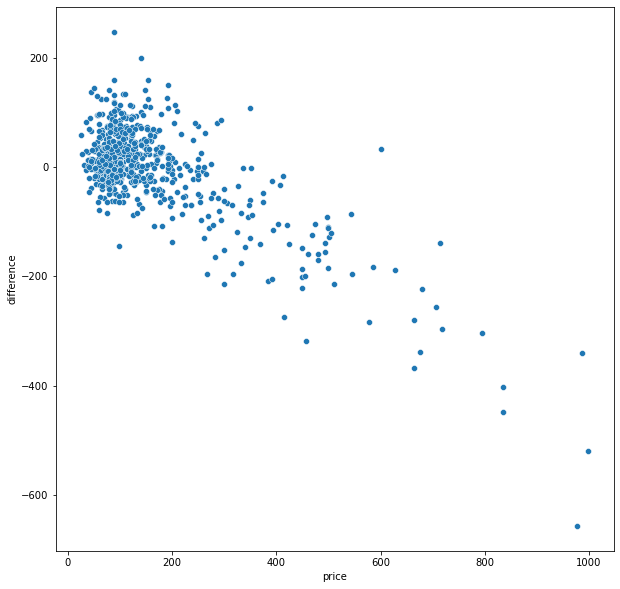

In [18]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.scatterplot(data = results, x='price', y='difference')

In [19]:
results[results['price']<200]

,index,price,predicted_price,difference
0,1165,39.0,67.264222,28.264222
1,1581,65.0,51.645485,-13.354515
3,668,110.0,164.213196,54.213196
4,71,75.0,95.889239,20.889239
7,459,115.0,206.866003,91.866003
...,...,...,...,...
662,135,89.0,85.460274,-3.539726
663,1753,142.0,66.543509,-75.456491
664,895,157.0,215.307320,58.307320
665,2072,102.0,201.884326,99.884326


<AxesSubplot:xlabel='price', ylabel='difference'>

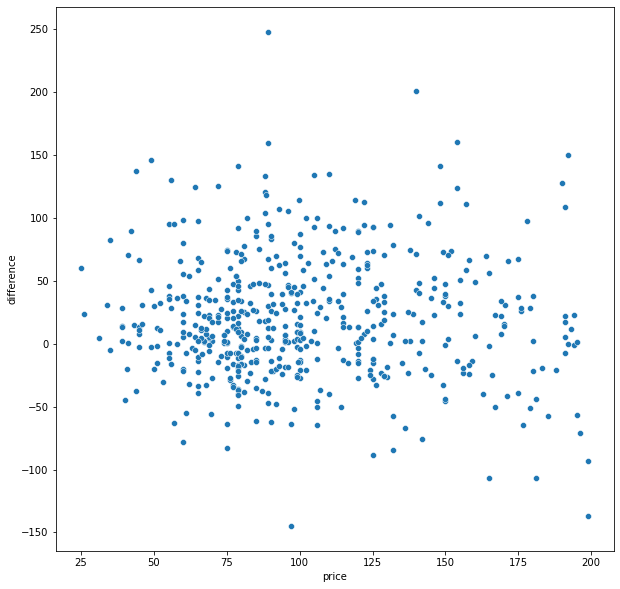

In [20]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.scatterplot(data = results[results['price']<200],x='price',y='difference')

In [21]:
from sklearn.dummy import DummyRegressor

In [22]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy_y = dummy.predict(X_test)
r2_score(y_test, dummy_y)

-0.0006454193788689722

# Ridge Regression 

In [23]:
from sklearn.linear_model import Ridge

In [24]:
ridge = Ridge()
params = {'alpha': [.1,.2,.3,.4,.5]+list(range(1,100))}
gridcv = GridSearchCV(ridge, param_grid=params, cv = 10)
gridcv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 6, 7,
                                   8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                   20, 21, 22, 23, 24, 25, ...]})

In [25]:
print(gridcv.best_params_)
print(gridcv.best_score_)

{'alpha': 51}
0.566387884727668


In [26]:
ridge = Ridge(alpha = 71)
ridge.fit(X_train, y_train)

Ridge(alpha=71)

In [27]:
y_pred  = ridge.predict(X_test)

In [28]:
r2_score(y_test, y_pred)

0.6213795927068058

# Random Forest

In [29]:
rf = RandomForestRegressor()
params = {'n_estimators':[1000]}
gridcv = GridSearchCV(rf, param_grid=params, cv = 5)
gridcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [1000]})

In [30]:
gridcv.best_score_

0.6017275005784604

In [31]:
rf=RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [32]:
y_pred = rf.predict(X_test)

In [33]:
r2_score(y_test, y_pred)

0.675790713061347

In [34]:
results=y_test.to_frame().reset_index()#creates dataframe to compare actual vs predicted prices
results['predicted_price']=pd.Series(y_pred)#adds a column for prices predicted by RF
results['predicted_price']=results.predicted_price#brings predicted prices back to scale from log
results['price']=results.price#brings test prices back to scale
results['residual'] =results.predicted_price-results.price#calculates residuals
results.head()

,index,price,predicted_price,residual
0,1165,39.0,65.52495,26.52495
1,1581,65.0,73.27994,8.27994
2,959,675.0,551.05231,-123.94769
3,668,110.0,145.98300,35.98300
4,71,75.0,77.63365,2.63365


<AxesSubplot:xlabel='price', ylabel='residual'>

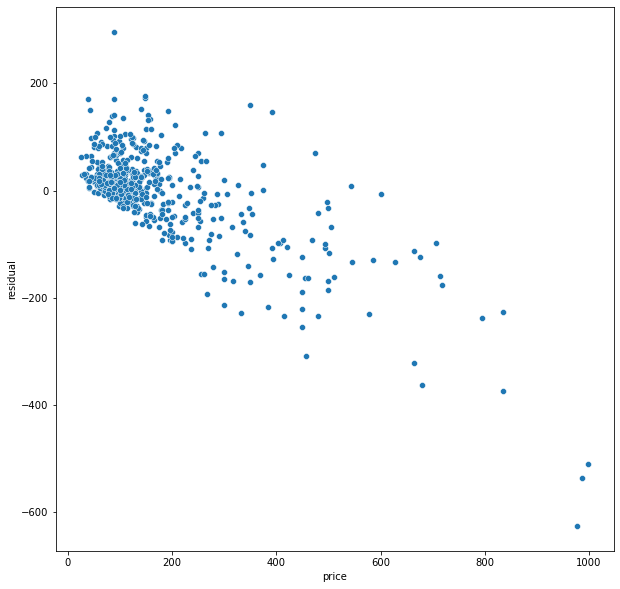

In [35]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = results, x='price', y='residual')

The r2 score is better for the random forest model, but the residual plot shows the same problem as the lasso model. As the airbnb in the test set becomes more expensive, the model is predicting a much lower price. 

In [36]:
importances = dict(zip(X_train,rf.feature_importances_))
importances =pd.DataFrame.from_dict(importances, orient ='index')
importances= importances.sort_values(by=0, ascending = False)
importances.head(20)

,0
bathrooms_text,0.295475
bedrooms,0.177446
reviews_per_month,0.054615
Median Sales Price,0.040598
availability_365,0.026641
amen_Pool,0.024623
beds,0.023107
days_active,0.020976
PercentShortTermRentals,0.020349
calculated_host_listings_count,0.018142


## Random Forest after removing outliers
#### This is an attempt to get the model to perform better by removing outliers from the features. This attempts to do this assuming test price isn't known so outliers can be removed from features in the test set, but outliers in the target variable will have to remain in the data. 

In [37]:
no_outliers_train = (X_train)
no_outliers_train["price"] = (y_train)
no_outliers_test = (X_test)
no_outliers_test['price'] = (y_test)

<ipython-input-37-b83138925a92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outliers_train["price"] = (y_train)
<ipython-input-37-b83138925a92>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outliers_test['price'] = (y_test)


In [38]:
columns = ["price"]
def remove_outliers(train, test, columns = columns):#function that takes a variable, calculates outliers (three standard deviations from the mean)
    global no_outliers_train                        #from only the training data and removes these outliers from training
    global no_outlers_test                          #and test data.
    for col in columns:
        med = np.median(train[col])
        std_p= np.std(train[col])
        outlier_high = (3*std_p) + med
        outlier_low = med - (3*std_p) 
        no_outliers_train = train[(train[col]<outlier_high) & (train[col]>outlier_low)]
        no_outliers_test  = test[(test[col]<outlier_high) & (test[col]>outlier_low)]

In [39]:
columns = ["price"]
remove_outliers(train = no_outliers_train, test = no_outliers_test)

In [40]:
print('This removed ' + str(airbnb.shape[0] - (no_outliers_test.shape[0] + no_outliers_train.shape[0])) +' rows')

This removed 48 rows


In [41]:
X_train_out = no_outliers_train.drop(columns = 'price')
y_train_out = no_outliers_train.price
X_test_out  = no_outliers_test.drop(columns = 'price')
y_test_out  = no_outliers_test.price

In [42]:
X_train_out.head()

,Median Sales Price,PercentShortTermRentals,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms_text,bedrooms,...,prop_Private room in guest suite,prop_Private room in guesthouse,prop_Private room in hostel,prop_Private room in house,prop_Private room in loft,prop_Private room in resort,prop_Private room in townhouse,prop_Room in aparthotel,prop_Room in boutique hotel,prop_Tiny house
48,515000.0,3.636364,100.0,100.0,1,1,0,2,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
110,206750.0,0.304878,100.0,93.0,1,1,1,8,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
2059,395000.0,9.724771,100.0,100.0,1,1,1,2,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
272,199750.0,2.005731,100.0,97.0,1,1,1,6,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
569,273750.0,9.274756,96.0,91.0,0,1,1,4,1.5,1.0,...,0,0,0,0,0,0,0,0,0,0


rf_outliers=RandomForestRegressor(n_estimators=1000)
params = {'max_depth':range(11,25)}
gridcv = GridSearchCV(rf_outliers, param_grid=params, cv = 5)
gridcv.fit(X_train_out, y_train_out)

print(gridcv.best_params_)
print(gridcv.best_score_)

In [43]:
rf_out=RandomForestRegressor(n_estimators=1000, max_depth = 24)
rf_out.fit(X_train_out, y_train_out)

RandomForestRegressor(max_depth=24, n_estimators=1000)

In [44]:
y_pred_out = rf.predict(X_test_out)

In [45]:
rf_out.score(X_test_out, y_test_out)

0.5379384525071274

In [46]:
results=y_test_out.to_frame().reset_index()
results['predicted_price']=pd.Series(y_pred_out)
results['predicted_price']=results.predicted_price
results['price']=results.price
results['residual'] =results.predicted_price-results.price
results.head()

,index,price,predicted_price,residual
0,1165,39.0,65.52495,26.52495
1,1581,65.0,73.27994,8.27994
2,959,675.0,551.05231,-123.94769
3,668,110.0,145.98300,35.98300
4,71,75.0,77.63365,2.63365


<AxesSubplot:xlabel='price', ylabel='residual'>

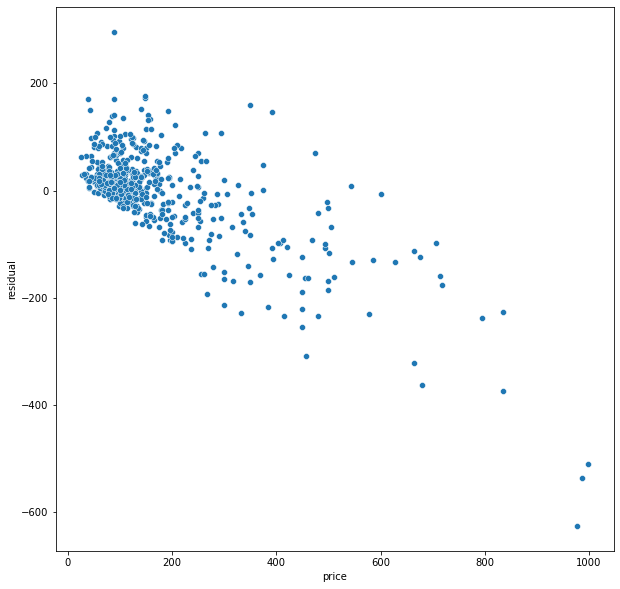

In [47]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = results, x='price', y='residual')

Removing target outliers did not improve the model.  The model may have performed worse because the outliers were removed only from the training data.  But

# Natural Language Processing 

At this point I believe the dataset is missing data that is important to describe the price of airbnbs.  People could be charging more for airbnbs with the hopes that they are only rented out a few times for a more expensive price. This could be tested with accurate information on the frequency and length of occupation. But that is data I don't have. 

Another possibility is there is some data that just isn't captured by the features I have. For instance, no features I have describe how new the airbnb is. No features contain information about the salesmanship of the owner.  Maybe renters are willing to pay more for an airbnb where the owner describes a certain way. I want to try a little more feature engineering to see if I can get some of this information.  I created another notebook where I extracted some basic features from host's descriptions of the airbnb and the neighborhood. Using vectorized natural language processing along with k-means unsupervised learning. 

In [48]:
text_data = pd.read_csv("../data/modeling/text_data.csv", index_col = 0)

In [49]:
text_data.head()

,neighborhood_description,description_group
0,0,1
1,0,2
2,0,0
3,0,2
4,0,3


In [50]:
airbnb = pd.concat([text_data, airbnb], axis = 1)

In [51]:
airbnb.head()

,neighborhood_description,description_group,Median Sales Price,PercentShortTermRentals,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,...,prop_Private room in guest suite,prop_Private room in guesthouse,prop_Private room in hostel,prop_Private room in house,prop_Private room in loft,prop_Private room in resort,prop_Private room in townhouse,prop_Room in aparthotel,prop_Room in boutique hotel,prop_Tiny house
0,0,1,134250.0,4.626335,100.0,100.0,1,1,1,8,...,0,0,0,0,0,0,0,0,0,0
1,0,2,134250.0,4.626335,96.0,98.0,0,1,1,6,...,0,0,0,0,0,0,0,0,0,0
2,0,0,134250.0,4.626335,100.0,84.0,1,1,1,4,...,0,0,0,0,0,0,0,0,0,0
3,0,2,134250.0,4.626335,95.0,99.0,0,1,1,6,...,0,0,0,0,0,0,0,0,0,0
4,0,3,134250.0,4.626335,100.0,100.0,0,1,1,8,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X_train, X_test = split(airbnb)

In [53]:
rf_text=RandomForestRegressor(n_estimators=1000) 
params = {'max_depth':range(27,40)} 
gridcv = GridSearchCV(rf_text, param_grid=params, cv = 5) 
gridcv.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_estimators=1000),
             param_grid={'max_depth': range(27, 40)})

In [54]:
print(gridcv.best_params_)
print(gridcv.best_score_)

{'max_depth': 28}
0.6011411278758494


In [61]:
rf_text=RandomForestRegressor(n_estimators=1000, max_depth = 28)
rf_text.fit(X_train, y_train)

RandomForestRegressor(max_depth=28, n_estimators=1000)

In [62]:
y_pred = rf_text.predict(X_test)

In [63]:
rf_text.score(X_test, y_test)

0.6761461824034192

In [1]:
!pip install xgboost

     |████████████████████████████████| 1.2 MB 2.3 MB/s eta 0:00:01


In [2]:
import xgboost as xg
from xgboost import XGBRegressor as xgb

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


Error: Cannot install under Rosetta 2 in ARM default prefix (/opt/homebrew)!
To rerun under ARM use:
    arch -arm64 brew install ...
To install under x86_64, install Homebrew into /usr/local.
Error: 'git' must be installed and in your PATH!
Error: Cannot install under Rosetta 2 in ARM default prefix (/opt/homebrew)!
To rerun under ARM use:
    arch -arm64 brew install ...
To install under x86_64, install Homebrew into /usr/local.
